# Predicting Taxi Fares with Deep Feedforward Networks

-----

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
CURRENT_DIR = Path('.').resolve()
MODULES_DIR = CURRENT_DIR.parent.joinpath('src')
sys.path.append(str(MODULES_DIR))
DATA_DIR = CURRENT_DIR.parent.joinpath('Data','Raw')

-----

We will use a deep feedforward neural network to predict taxo fares in New York City, given inputs such as the pickup and drop off locations

-----

## The NYC taxi fares dataset

The dataset that we will be use for this project is the NYC taxi fares dataset, as provided by Kaggle. The original datset constains a massive 55 million trip records from 2009 to 2015, incluidin data such as the pick up and drop off locations, number of passengers and pickup datetime.

-----

## Exploratory data analysis

Let's just import the first 0.5 millon rows. Doing this does have its drawbacks, but is a necessary tradeoff in order to use the dataset in a efficent manner


In [7]:
df = pd.read_csv(str(DATA_DIR.joinpath('train.csv')),parse_dates=['pickup_datetime'],
                 nrows=500000)

In [8]:
df= df.drop(columns='key')

In [9]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [10]:
df.shape

(500000, 7)

First. let's restric our data points to only pickups and drop off within NYC. NYC has an approximate longitude range of -74.05 to -73.75 and latitude range of 40.63 to 40.85

In [11]:
# range of longitude for NYC
nyc_min_longitude = -74.05
nyc_max_longitude = -73.75

# range of latitude for NYC
nyc_min_latitude = 40.63
nyc_max_latitude = 40.85

df2 = df.copy(deep=True)
for long in ['pickup_longitude','dropoff_longitude']:
    df2 = df2[(df2[long]>nyc_min_longitude) & (df2[long]< nyc_max_longitude)]
    
for lat in ['pickup_latitude','dropoff_latitude']:
    df2 = df2[(df2[lat]> nyc_min_latitude) & (df2[lat]<nyc_max_latitude)]

In [12]:
df2.shape

(483500, 7)

Now, let's define a new function that will take our DataFrame as an input, and plot the pickup locations on a scatterplot. We are also interested in overlaying the scatterplot with a few key landmarks in NYC.

In [13]:
landmarks = {'JFK Airport': (-73.78, 40.643),
'Laguardia Airport': (-73.87, 40.77),
'Midtown': (-73.98, 40.76),
'Lower Manhattan': (-74.00, 40.72),
'Upper Manhattan': (-73.94, 40.82),
'Brooklyn': (-73.95, 40.66)}

In [14]:
import visaulization as vis

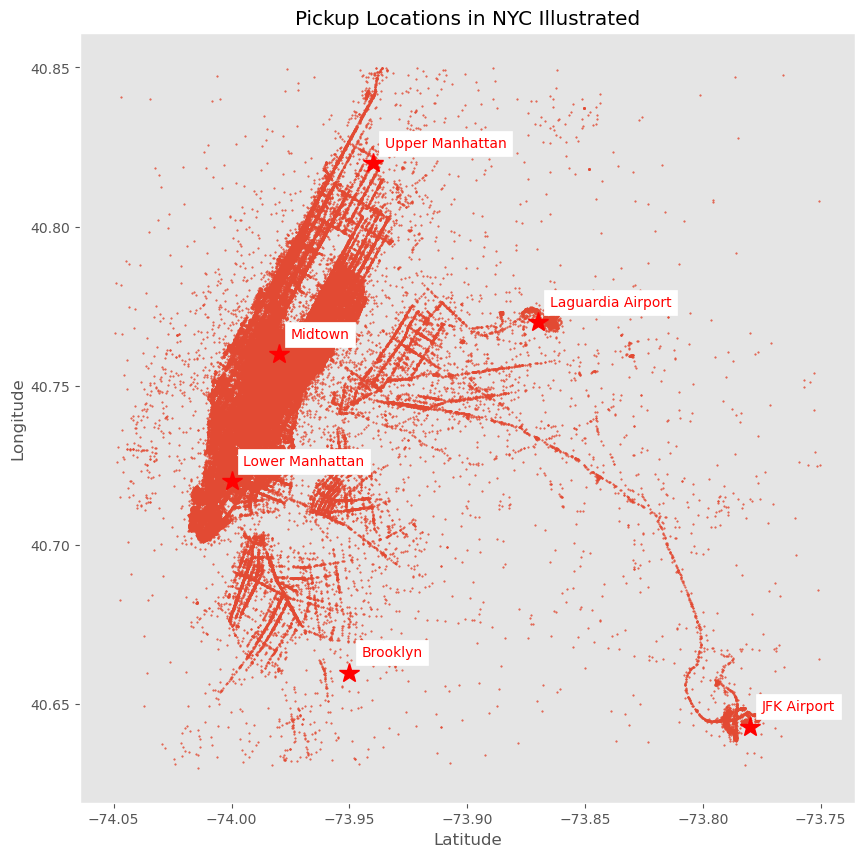

In [15]:
vis.plot_lat_long(df2,landmarks,'Pickup')

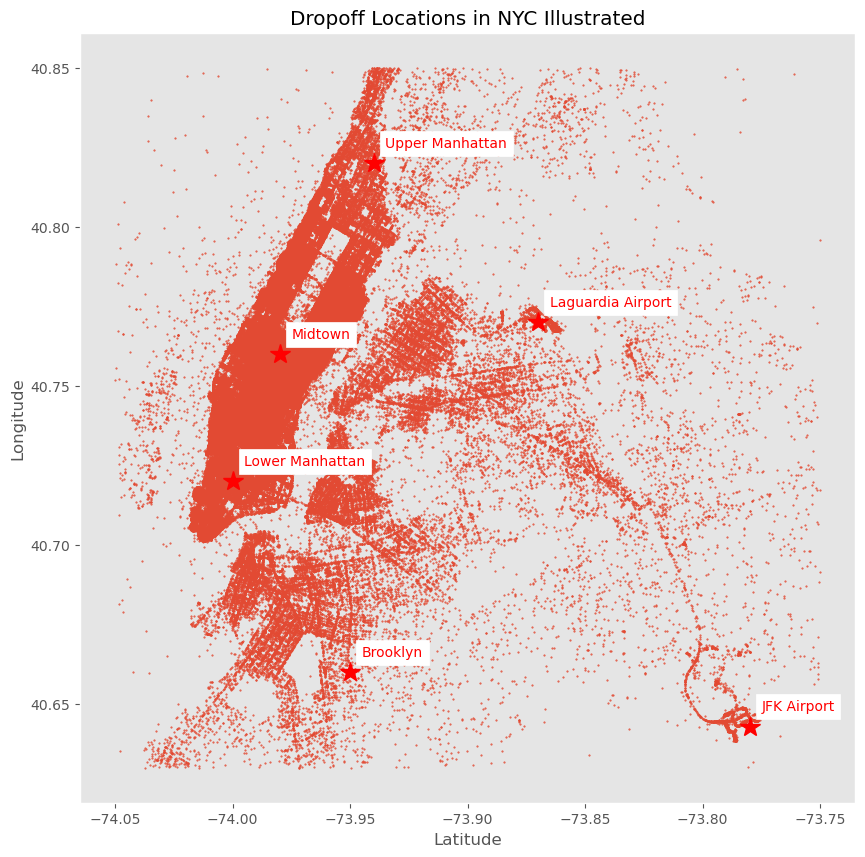

In [16]:
vis.plot_lat_long(df2,landmarks,'Dropoff')

## Ridership by day and hour

Let's investigate how the number of rides varies by day and hour

In [17]:
df['year']=df['pickup_datetime'].dt.year
df['month']=df['pickup_datetime'].dt.month
df['day']=df['pickup_datetime'].dt.day
df['day_of_week']=df['pickup_datetime'].dt.day_of_week
df['hour']=df['pickup_datetime'].dt.hour

In [18]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7


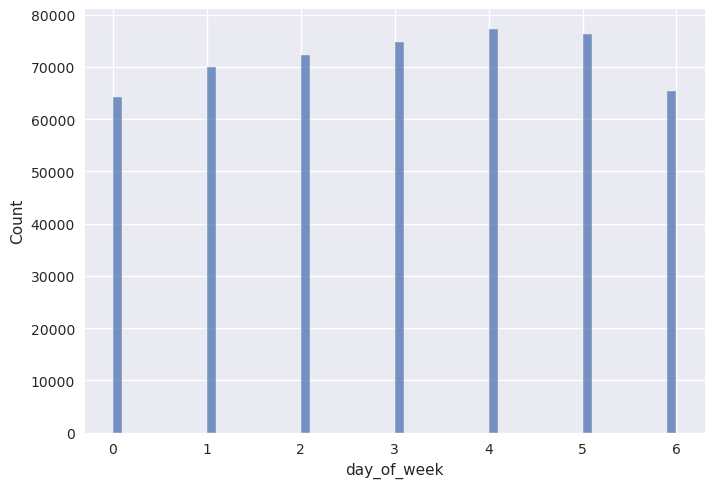

In [19]:
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.histplot(data=df,
             x='day_of_week')
plt.show()

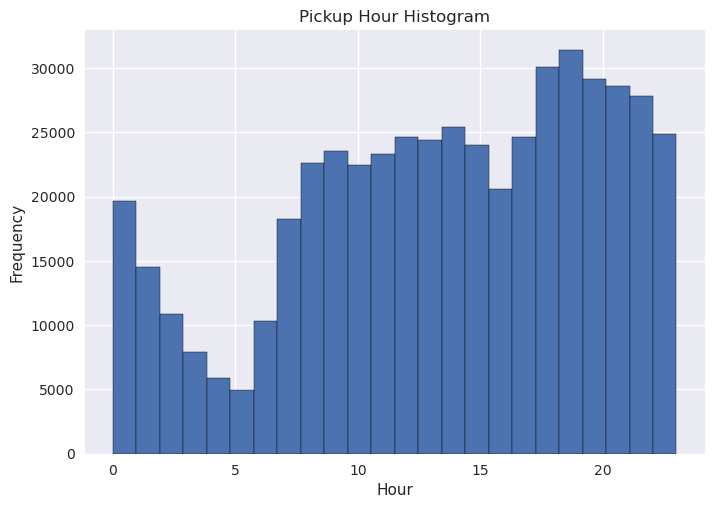

In [20]:
df['hour'].plot.hist(bins=24, ec='black')
plt.title('Pickup Hour Histogram')
plt.xlabel('Hour')
plt.show()

-----

# Data preprocessing

## Handling missing values and data anomalies

Let's do a check to see whether there ara any missing values in our dataset:

In [21]:
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
year                 0
month                0
day                  0
day_of_week          0
hour                 0
dtype: int64

We can see that there are only five rows with missing data. Let's go ahead and remove those five rows with missing data

In [22]:
df = df.dropna()

In [23]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
count,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000
mean,11.358182,-72.520091,39.920350,-72.522435,39.916526,1.683445,2011.739129,6.268617,15.684239,3.042020,13.510843
std,9.916069,11.856446,8.073318,11.797362,7.391002,1.307391,1.860897,3.437798,8.681092,1.949243,6.511596
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,-73.992047,40.734916,-73.991382,40.734057,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000


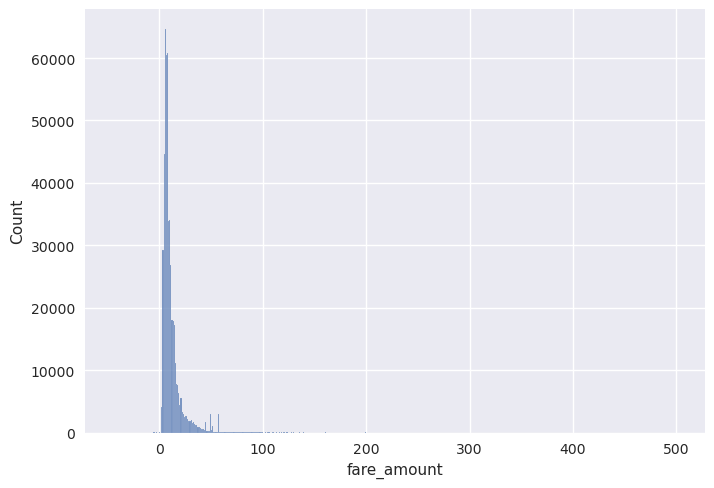

In [24]:
sns.histplot(data=df,
             x='fare_amount',
             bins=500)
plt.show()

For now, let's remove rows with fares less than $0 and more than $100

In [25]:
df = df[(df['fare_amount'] >= 0) & (df['fare_amount'] <= 100)]
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
count,499760.000000,499760.000000,499760.000000,499760.000000,499760.000000,499760.00000,499760.000000,499760.000000,499760.000000,499760.000000,499760.000000
mean,11.300049,-72.522405,39.921591,-72.525784,39.918307,1.68358,2011.738677,6.268683,15.684080,3.042068,13.510963
std,9.400215,11.850322,8.071247,11.788054,7.386892,1.30753,1.860821,3.437844,8.681169,1.949242,6.511278
min,0.000000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.00000,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,-73.992049,40.734926,-73.991380,40.734062,1.00000,2010.000000,3.000000,8.000000,1.000000,9.000000
50%,8.500000,-73.981788,40.752674,-73.980128,40.753152,1.00000,2012.000000,6.000000,16.000000,3.000000,14.000000
75%,12.500000,-73.967133,40.767072,-73.963587,40.768125,2.00000,2013.000000,9.000000,23.000000,5.000000,19.000000
max,100.000000,2140.601160,1703.092772,40.851027,404.616667,6.00000,2015.000000,12.000000,31.000000,6.000000,23.000000


From the previous table, we can see that thare are also outliers in the `passenger_count` column. Let's plot a histogram of `Passanger Count` to look at its distribution

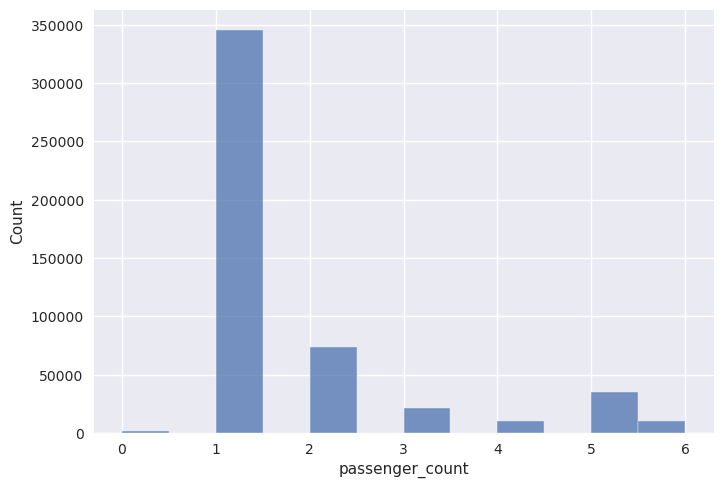

In [26]:
sns.histplot(data=df,
             x='passenger_count',
             binwidth=0.5)
plt.show()

In [27]:
df.loc[df['passenger_count']==0,'passenger_count'] = 1

In [28]:
df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day', 'day_of_week', 'hour'],
      dtype='object')

Let's inspect the pickup and drop off latitude and longitude data to check for outliers.

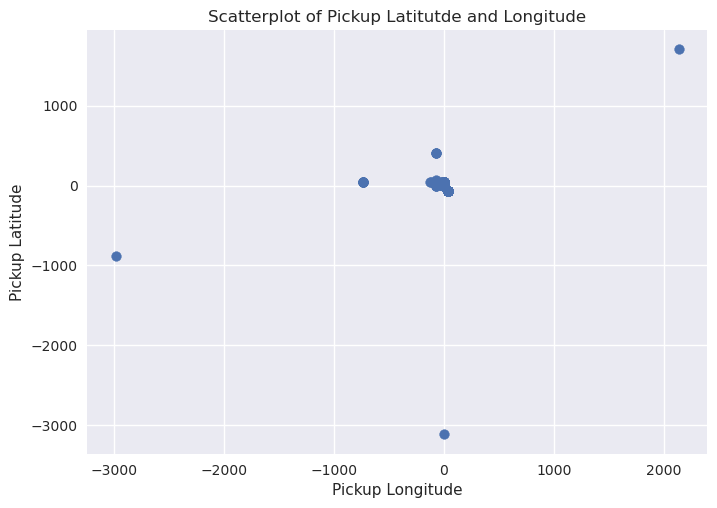

In [29]:
fig, ax = plt.subplots()
ax.scatter(x=df.pickup_longitude,
           y=df.pickup_latitude)
ax.set_title('Scatterplot of Pickup Latitutde and Longitude')
ax.set_xlabel('Pickup Longitude')
ax.set_ylabel('Pickup Latitude')
plt.show()

They have latitude values as high as 1000 and as low as -3000. Earth's geographic cordiante system does not have such extreme latitudes and longitudes. We will remove these outliers

In [30]:
# range of longitude for NYC
nyc_min_longitude = -74.05
nyc_max_longitude = -73.75

# range of latitude for NYC
nyc_min_latitude = 40.63
nyc_max_latitude = 40.85

for long in ['pickup_longitude','dropoff_longitude']:
    df = df[(df[long]>nyc_min_longitude) & (df[long]< nyc_max_longitude)]

for lat in ['pickup_latitude','dropoff_latitude']:
    df = df[(df[lat]>nyc_min_latitude) & (df[lat]< nyc_max_latitude)]

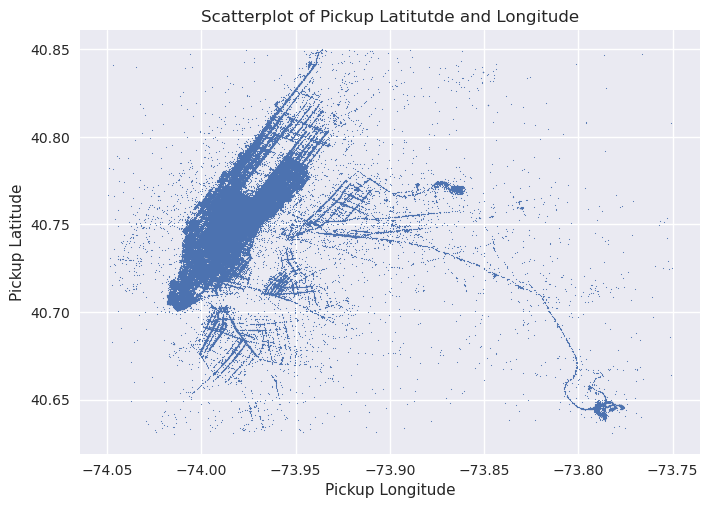

In [31]:
fig, ax = plt.subplots()
ax.scatter(x=df.pickup_longitude,
           y=df.pickup_latitude,
           marker='.',
           s=1)
ax.set_title('Scatterplot of Pickup Latitutde and Longitude')
ax.set_xlabel('Pickup Longitude')
ax.set_ylabel('Pickup Latitude')
plt.show()

In [37]:
DATA_SAVE = DATA_DIR.parent.joinpath('Preprocess')
df.to_csv(str(DATA_SAVE.joinpath('taxi.csv')))